In [1]:
import os
import jax #pip install jax
#os.environ["JAX_PLATFORMS"] = "cpu"  # Forces JAX to run on CPU
print(f"JAX is using: {jax.devices()[0]}")
import pickle
import jaxmarl
from jaxmarl.environments.switch_riddle import make_train
from jaxmarl.viz.overcooked_visualizer import OvercookedVisualizer
from datetime import datetime
import sys
import time
import re
from textwrap import dedent
import csv
import pandas as pd
import matplotlib.pyplot as plt


CUDA backend failed to initialize: Unable to use CUDA because of the following issues with CUDA components:
Outdated CUDA installation found.
Version JAX was built against: 12030
Minimum supported: 12010
Installed version: 12000
The local installation version must be no lower than 12010.
--------------------------------------------------
Outdated cuBLAS installation found.
Version JAX was built against: 120304
Minimum supported: 120100
Installed version: 120002
The local installation version must be no lower than 120100.
--------------------------------------------------
Outdated cuSPARSE installation found.
Version JAX was built against: 12200
Minimum supported: 12100
Installed version: 12001
The local installation version must be no lower than 12100..(Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


JAX is using: TFRT_CPU_0


In [2]:
# Save the model parameters only
def save_model(runner_state, save_dir, file):
    # Ensure the save directory exists
    os.makedirs(save_dir, exist_ok=True)

    # Construct the full file path
    filename = os.path.join(save_dir, file)

    # Extract train_state (first element of the tuple)
    train_state_1 = runner_state[0]
    train_state_2 = runner_state[1]

    # Save only the model parameters
    with open(filename, 'wb') as f:
        pickle.dump({'params_1': train_state_1.params, 
                     'params_2': train_state_2.params}, f)


    print(f"Model parameters saved to {filename}")

# Load the model parameters
def load_model(load_dir, file):
    filename = os.path.join(load_dir, file)

    if not os.path.exists(filename):
        raise FileNotFoundError(f"Model file {filename} not found.")

    with open(filename, "rb") as f:
        saved_data = pickle.load(f)

    # Ensure the loaded model has the correct parameter structure
    if "params_1" not in saved_data or "params_2" not in saved_data:
        raise ValueError("Invalid saved model file.")

    model_params_1 = saved_data["params_1"]
    model_params_2 = saved_data["params_2"]
    print(f"Model parameters loaded from {filename}")

    return model_params_1, model_params_2

def find_closest_checkpoint(fixed_step, load_dir):
    # List all files in the directory
    files = os.listdir(load_dir)
    
    # Filter files that match the pattern 'trained_model_{step}.pkl'
    checkpoint_files = [f for f in files if f.startswith("trained_model_") and f.endswith(".pkl")]
    
    # Extract the step numbers from the filenames
    steps = []
    for file in checkpoint_files:
        step_str = file.split('_')[-1].split('.')[0]  # Extract the step number
        try:
            step = int(step_str)
            steps.append(step)
        except ValueError:
            continue  # Skip files that don't have a valid step number
    
    if len(steps) == 0:
        raise FileNotFoundError(f"No checkpoint files found in {load_dir}")
    
    # Find the closest step to the fixed step
    closest_step = min(steps, key=lambda x: abs(x - fixed_step))
    closest_filename = f"trained_model_{closest_step}.pkl"
    
    print(f"Found checkpoint: {closest_filename} for step {closest_step}")
    
    # Load the model (assuming load_model function is available)
    model_params_1, model_params_2 = load_model(load_dir, closest_filename)
    
    return model_params_1, model_params_2, closest_step

In [3]:
def make_config(config):
    """Enhances config with additional computed parameters and prints it in a readable format."""
    env = jaxmarl.make(config["ENV_NAME"], **config["ENV_KWARGS"])

    # Compute additional parameters
    config["NUM_ACTORS"] = env.num_agents * config["NUM_ENVS"]
    config["NUM_UPDATES"] = int(config["TOTAL_TIMESTEPS"] // config["NUM_STEPS"] // config["NUM_ENVS"])
    config["NUM_SAVES"] = int(config["NUM_UPDATES"] // config["SAVE_EVERY_N_EPOCHS"])
    config["MINIBATCH_SIZE"] = (
        int(config["NUM_ACTORS"] / 2) * config["NUM_STEPS"] // config["NUM_MINIBATCHES"]
    )

    # Print all configuration settings in a structured way
    print("\n===== CONFIGURATION SETTINGS =====")
    for key in sorted(config.keys()):  # Sort keys alphabetically for readability
        print(f"{key}: {config[key]}")
    print("==================================\n")

    return config


TRAINING

In [4]:
cluster = "cuenca"

current_datetime = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

if cluster == "cuenca":
    initial_dir = f'/data/samuel_lozano/hfsp_collective_learning/data_switch_riddle/Asymmetric_Agents/Checkpoints_{current_datetime}/'
elif cluster == "brigit":
    initial_dir = f'/mnt/lustre/home/samuloza/data/samuel_lozano/hfsp_collective_learning/data_switch_riddle/Asymmetric_Agents/Checkpoints_{current_datetime}/'
else:
    print("Introduce a valid cluster name")

# Save the original stdout reference (ONLY NOTEBOOKS)
original_stdout = sys.stdout  

# Create the directory if it does not exist
os.makedirs(initial_dir, exist_ok=True)

# Define the output file name
log_filename = f"configuration_{current_datetime}.txt"
log_filepath = os.path.join(initial_dir, log_filename)

# Redirect standard output to a file
with open(log_filepath, "w") as log_file:
    sys.stdout = log_file  # Redirect stdout to the file

    print(f"Timestamp: {current_datetime}\n")

    # set hyperparameters:
    config = {
        # Number of possible actions in the environment. 
        "NUM_ACTIONS": 6, 
        # Controls how much the model updates its weights during optimization.
        "LR": 1e-4, 
        # Number of parallel environments running simultaneously.
        "NUM_ENVS": 8, 
        #Number of steps collected before running an update.
        "NUM_STEPS": 1600, 
        # Total number of timesteps for training.
        "TOTAL_TIMESTEPS": 1e7, 
        # Number of times each collected batch of experiences is used for gradient updates. More epochs allow for better learning from collected data but can lead to overfitting.
        "UPDATE_EPOCHS": 4, 
        # Number of minibatches used during training updates. More minibatches reduce variance but increase computational cost.
        "NUM_MINIBATCHES": 4, 
        # Discount factor for future rewards. A value close to 1 favors long-term rewards, while lower values prioritize immediate rewards.
        "GAMMA": 0.99, 
        # Controls Generalized Advantage Estimation (GAE). Higher values lead to smoother, less biased advantage estimates.
        "GAE_LAMBDA": 0.99, 
        # PPO-specific parameter that limits policy updates to prevent excessive changes. Lower values ensure stability but may slow training.
        "CLIP_EPS": 0.2, 
        # Coefficient for entropy regularization, encouraging exploration. Higher values lead to more randomness in actions.
        "ENT_COEF": 0.1, 
        # Coefficient for the value function loss. Higher values prioritize accurate value function learning.
        "VF_COEF": 0.5, 
        # Limits the magnitude of gradients, preventing instability.
        "MAX_GRAD_NORM": 0.5, 
        # Specifies the activation function for the network. Tanh helps with stable gradient flow but might limit expressiveness compared to ReLU.
        "ACTIVATION": "tanh",
        # The RL environment being used.
        "ENV_NAME": "switch_riddle",
        # Allows customization of environment settings, such as custom layouts.
        "ENV_KWARGS": {
        },
        # If enabled, the learning rate decreases over time, improving stability in later training stages.
        "ANNEAL_LR": True, 
        # Ensures reproducibility by fixing the random seed.
        "SEED": 0,
        # Runs multiple training instances with different seeds for robustness.
        "NUM_SEEDS": 3,
        # Saves model checkpoints every N epochs.
        "SAVE_EVERY_N_EPOCHS": 50,
    }
    
    config = make_config(config)

    log_file.flush()

# Restore standard output to the console
sys.stdout = original_stdout

print(f"Configuration saved in {log_filepath}")

rng = jax.random.PRNGKey(config["SEED"])
rngs = jax.random.split(rng, config["NUM_SEEDS"])
csv_file_path = f'{initial_dir}mean_return_data_{current_datetime}.csv'
os.makedirs(initial_dir, exist_ok=True)

with open(csv_file_path, mode='a', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["seed", "step", "mean_returns"])

# Training loop
for seed in range(config["NUM_SEEDS"]):
    train_jit = make_train(config)
    result = train_jit(seed, rngs[seed], initial_dir, csv_file_path)
    print(f"Data saved in {initial_dir}")

Configuration saved in /data/samuel_lozano/hfsp_collective_learning/data_switch_riddle/Asymmetric_Agents/Checkpoints_2025-05-29_18-08-54/configuration_2025-05-29_18-08-54.txt
agent_0
agent_1
agent_2


TypeError: Value 'agent_0' with type <class 'str'> is not a valid JAX type

RECREATING RESULTS OF TRAINING

In [ ]:
#OLD (WITHOUT CSV, WITH NPZ)

def recreate_results(load_layout_name, load_datetime, show_figure=1):
    original_dir = f'/data/samuel_lozano/hfsp_collective_learning/data_switch_riddle/Asymmetric_Agents/{load_layout_name}/Checkpoints_{load_datetime}/'
    # Find all files matching the pattern "plot_data_seed_{seed}.npz"
    seed_files = [f for f in os.listdir(original_dir) if re.match(r"plot_data_seed_\d+\.npz", f)]
    seed_files.sort(key=lambda x: int(re.findall(r"\d+", x)[0]))  # Sort by seed number

    if not seed_files:
        print("No seed files found!")
        return None, None, None
    
    max_steps_per_seed = {}
    mean_returns_per_seed = [] 

    i = 0
    for file in seed_files:
        file_path = os.path.join(original_dir, file)
        data = np.load(file_path, allow_pickle=True)
        returns_list = jnp.expand_dims(data["returns"], axis=0)
        out_reconstructed = [{"metrics": {"returned_episode_returns": returns}} for returns in returns_list]
    
        returns = jnp.stack(out_reconstructed[0]["metrics"]["returned_episode_returns"])
        mean_returns = returns.mean(axis=-1).reshape(-1)

        mean_returns_per_seed.append(mean_returns)
        
        max_index = int(jnp.argmax(mean_returns))  # Index of max return
        max_step = max_index / config["NUM_STEPS"]  # Convert to update steps
        max_value = float(mean_returns[max_index])  # Get max value
        
        max_steps_per_seed[f"Seed {i}"] = (max_step, max_value)

        i += 1
        
    # Recreate the plot
    if show_figure == 1:
        plt.figure()
        for i in range(len(seed_files)):
            plt.plot(mean_returns_per_seed[i], label=f"Seed {i}")
    
        plt.xlabel("Update Step")
        plt.ylabel("Return")
        plt.legend()
    
        save_path = os.path.join(original_dir, f"plot_{load_layout_name}_{load_datetime}.png")
        plt.savefig(save_path)
        plt.show()

    print("Max steps per seed (reconstructed):")
    print(max_steps_per_seed)
    return mean_returns_per_seed, max_steps_per_seed

In [ ]:
config={}
config["NUM_STEPS"] = 1000

# Directory containing the seed files
load_datetime = '2025-03-22_14-11-41'

# Run the function
show_figure = 1
mean_returns_per_seed, max_steps_per_seed = recreate_results(load_datetime, show_figure=show_figure)

In [ ]:
def recreate_results_csv(cluster, load_datetime, show_figure=1):
    if cluster == "cuenca":
        original_dir = f'/data/samuel_lozano/hfsp_collective_learning/data_switch_riddle/Asymmetric_Agents/Checkpoints_{load_datetime}/'
    elif cluster == "brigit":
        original_dir = f'/mnt/lustre/home/samuloza/data/samuel_lozano/hfsp_collective_learning/data_switch_riddle/Asymmetric_Agents/Checkpoints_{load_datetime}/'
    else:
        print("Introduce a valid cluster name")
        return

    data = pd.read_csv(f'{original_dir}mean_return_data_{load_datetime}.csv')
    max_steps_per_seed = {}
    mean_returns_per_seed = []

    for seed in data['seed'].unique():
        seed_data = data[data['seed'] == seed]
        seed_data = seed_data.sort_values('step')
        
        mean_returns = seed_data['mean_returns'].apply(lambda x: float(x.strip('[]'))).to_numpy()
        mean_returns_per_seed.append(mean_returns)

        max_index = int(jnp.argmax(mean_returns))  # Index of max return
        max_value = float(mean_returns[max_index])  # Get max value
        
        max_steps_per_seed[f"Seed {seed}"] = (max_index, max_value)
    
    if show_figure == 1:
        plt.figure()
        for seed_index in range(len(mean_returns_per_seed)):
            steps = data[data['seed'] == seed_index]['step'].unique()  
            plt.plot(steps, mean_returns_per_seed[seed_index], label=f'Seed {seed_index}')
    
        plt.xlabel('Update Step')
        plt.ylabel('Mean Returns')
        plt.ylim(-10, 175)
        plt.legend() 
        
        save_path = os.path.join(original_dir, f"plot_{load_datetime}.png")
        plt.savefig(save_path)
        plt.show()

    print("Max steps per seed (reconstructed):")
    print(max_steps_per_seed)
    return mean_returns_per_seed, max_steps_per_seed

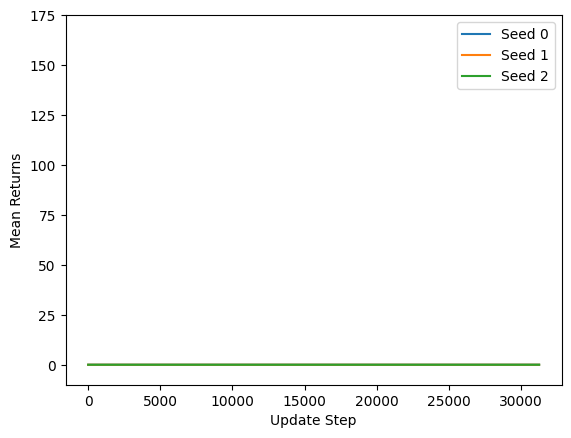

Max steps per seed (reconstructed):
{'Seed 0': (0, 0.0), 'Seed 1': (0, 0.0), 'Seed 2': (0, 0.0)}


In [ ]:
# Directory containing the seed files
cluster = "brigit"
load_datetime = '2025-04-03_08-02-47'
load_layout_name = 'custom_13'

# Run the function
show_figure = 1
mean_returns_per_seed, max_steps_per_seed = recreate_results_csv(cluster, load_layout_name, load_datetime, show_figure=show_figure)

In [ ]:
max_steps = int(3.15e3)

plt.figure() 
for i in range(len(mean_returns_per_seed)):    
    plt.plot(mean_returns_per_seed[i][:max_steps], label=f"Seed {i}")

plt.xlabel("Update Step")
plt.ylabel("Return")
plt.ylim(-10, 195)
plt.legend()

if cluster == "cuenca":
    original_dir = f'/data/samuel_lozano/hfsp_collective_learning/data_switch_riddle/Asymmetric_Agents/{load_layout_name}/Checkpoints_{load_datetime}/'
elif cluster == "brigit":
    original_dir = f'/mnt/lustre/home/samuloza/data/samuel_lozano/hfsp_collective_learning/data_switch_riddle/Asymmetric_Agents/{load_layout_name}/Checkpoints_{load_datetime}/'
else:
    print("Introduce a valid cluster name")

save_path = os.path.join(original_dir, f"plot_zoom_{load_layout_name}_{load_datetime}.png")
plt.savefig(save_path)
plt.show()

In [ ]:
def find_value_return_interval(seed, mean_returns_per_seed, config, searched_value, min_step, max_step):
    for step in range(int(min_step), int(max_step + 1)):
        scaled_step = step // config["NUM_STEPS"]  # Adjust step according to NUM_STEPS
        if mean_returns_per_seed[seed][step] == searched_value:
            print(f"First return value {searched_value} in seed {seed} at update_step: {step}. In update step: {scaled_step}")
            return scaled_step

    print(f"No return value {searched_value} found in seed {seed} within the specified range.")
    return None

def find_different_value_return_interval(seed, mean_returns_per_seed, config, searched_value, min_step, max_step):
    for step in range(int(min_step), int(max_step + 1)):
        scaled_step = step // config["NUM_STEPS"]  # Adjust step according to NUM_STEPS
        if mean_returns_per_seed[seed][step] != searched_value:
            print(f"First return value {searched_value} in seed {seed} at update_step: {step}. In update step: {scaled_step}")
            return scaled_step

    print(f"No return value {searched_value} found in seed {seed} within the specified range.")
    return None

In [ ]:
seed = 2
searched_value = 0
min_step = 4e6
max_step = 4.3e6

found_step = find_value_return_interval(seed, mean_returns_per_seed, config, searched_value, min_step, max_step)

In [ ]:
def get_trained_steps(load_layout_name, load_datetime, mean_returns_per_seed, min_value, max_value, seed=None):
    if cluster == "cuenca":
        original_dir = f'/data/samuel_lozano/hfsp_collective_learning/data_switch_riddle/Asymmetric_Agents/{load_layout_name}/Checkpoints_{load_datetime}/'
    elif cluster == "brigit":
        original_dir = f'/mnt/lustre/home/samuloza/data/samuel_lozano/hfsp_collective_learning/data_switch_riddle/Asymmetric_Agents/{load_layout_name}/Checkpoints_{load_datetime}/'
    else:
        print("Introduce a valid cluster name")
        return

    step_pattern = re.compile(r"trained_model_(\d+)\.pkl")

    results = {}  # Final dictionary with the reconstructed values

    seed_path = os.path.join(original_dir, f"Seed_{seed}")   
    if os.path.isdir(seed_path):
        steps = []
        for file in os.listdir(seed_path):
            step_match = step_pattern.match(file)
            if step_match and min_value <= int(step_match.group(1)) and max_value >= int(step_match.group(1)):
                steps.append(int(step_match.group(1)))

        steps.sort()
        for step in steps:                 
            results[step] = mean_returns_per_seed[seed][step]

    return results

In [ ]:
seed = 0
min_value = int(0e0)
max_value = int(4e4)

steps_per_seed = get_trained_steps(load_layout_name, load_datetime, mean_returns_per_seed, min_value, max_value, seed)
print(steps_per_seed)

# Get the key with the maximum value
max_key = max(steps_per_seed, key=steps_per_seed.get)

# Print the key and its corresponding value
print(f"Key with the highest value: {max_key}, Value: {steps_per_seed[max_key]}")

{0: 0.0, 50: 0.0, 100: 0.0, 150: 0.0, 200: 0.0, 250: 0.0, 300: 0.0, 350: 0.0, 400: 0.0, 450: 0.0, 500: 0.0, 550: 0.0, 600: 0.0, 650: 0.0, 700: 0.0, 750: 0.0, 800: 0.0, 850: 0.0, 900: 0.0, 950: 0.0, 1000: 0.0, 1050: 0.0, 1100: 0.0, 1150: 0.0, 1200: 0.0, 1250: 0.0, 1300: 0.0, 1350: 0.0, 1400: 0.0, 1450: 0.0, 1500: 0.0, 1550: 0.0, 1600: 0.0, 1650: 0.0, 1700: 0.0, 1750: 0.0, 1800: 0.0, 1850: 0.0, 1900: 0.0, 1950: 0.0, 2000: 0.0, 2050: 0.0, 2100: 0.0, 2150: 0.0, 2200: 0.0, 2250: 0.0, 2300: 0.0, 2350: 0.0, 2400: 0.0, 2450: 0.0, 2500: 0.0, 2550: 0.0, 2600: 0.0, 2650: 0.0, 2700: 0.0, 2750: 0.0, 2800: 0.0, 2850: 0.0, 2900: 0.0, 2950: 0.0, 3000: 0.0, 3050: 0.0, 3100: 0.0, 3150: 0.0, 3200: 0.0, 3250: 0.0, 3300: 0.0, 3350: 0.0, 3400: 0.0, 3450: 0.0, 3500: 0.0, 3550: 0.0, 3600: 0.0, 3650: 0.0, 3700: 0.0, 3750: 0.0, 3800: 0.0, 3850: 0.0, 3900: 0.0, 3950: 0.0, 4000: 0.0, 4050: 0.0, 4100: 0.0, 4150: 0.0, 4200: 0.0, 4250: 0.0, 4300: 0.0, 4350: 0.0, 4400: 0.0, 4450: 0.0, 4500: 0.0, 4550: 0.0, 4600: 0.0,

LOADING AND EVALUATING

In [ ]:
fixed_step = 26200  # Change this to the desired step

seed_idx = 0  # Change if needed

#cluster = "brigit"
#load_datetime = '2025-03-26_14-56-22'
#load_layout_name = 'custom_8'
custom_layout = load_custom_layout(load_layout_name)

if cluster == "cuenca":
    original_dir = f'/data/samuel_lozano/hfsp_collective_learning/data_switch_riddle/Asymmetric_Agents/{load_layout_name}/Checkpoints_{load_datetime}/'
elif cluster == "brigit":
    original_dir = f'/mnt/lustre/home/samuloza/data/samuel_lozano/hfsp_collective_learning/data_switch_riddle/Asymmetric_Agents/{load_layout_name}/Checkpoints_{load_datetime}/'
else:
    print("Introduce a valid cluster name")

load_dir = f"{original_dir}Seed_{seed_idx}/"
load_filename = f"trained_model_{fixed_step}.pkl"

num_actions = 6
activation = "tanh"

# Initialize network
network_1 = ActorCritic(num_actions, activation)
network_2 = ActorCritic(num_actions, activation)

# Load parameters into the network
model_params_1, model_params_2, closest_step = find_closest_checkpoint(fixed_step, load_dir)

print(f"Model restored successfully from step {closest_step}")

if 'mean_returns_per_seed' in locals() or 'mean_returns_per_seed' in globals():
    return_value = f"{mean_returns_per_seed[seed_idx][closest_step]:.3f}".replace(".", "_")
    print(f"with mean return {float(mean_returns_per_seed[seed_idx][closest_step])}!")

Found checkpoint: trained_model_26200.pkl for step 26200
Model parameters loaded from /mnt/lustre/home/samuloza/data/samuel_lozano/hfsp_collective_learning/data_overcooked_original/Asymmetric_Agents/custom_13/Checkpoints_2025-04-03_01-04-00/Seed_0/trained_model_26200.pkl
Model restored successfully from step 26200
with mean return 128.5!


In [ ]:
# Set environment parameters
max_steps = 1000
key = jax.random.PRNGKey(0)
key, key_r, key_a = jax.random.split(key, 3)


# Instantiate environment
env = make('switch_riddle', max_steps=max_steps)

# Reset environment
obs, state = env.reset(key_r)
print('List of agents in environment:', env.agents)

# Visualization setup
viz = OvercookedVisualizer()
state_seq = []

List of agents in environment: ['agent_0', 'agent_1']


In [ ]:
# Run environment loop using the trained model
for _ in range(max_steps):
    state_seq.append(state)
    
    # Get model-based actions
    key, key_s = jax.random.split(key)
    
    actions = {}
    for i, agent in enumerate(env.agents):
        agent_obs = obs[agent]  # Extract observation for each agent
        
        # Choose the correct network for the current agent
        if i == 0:
            action_logits, value = network_1.apply(model_params_1, agent_obs.flatten())  # Get model's action distribution
        elif i == 1:
            action_logits, value = network_2.apply(model_params_2, agent_obs.flatten())  # Get model's action distribution
        
        action = action_logits.sample(seed=key_s)
        key, key_s = jax.random.split(key)

        actions[agent] = action
    
    # Step environment
    obs, state, rewards, dones, infos = env.step(key_s, state, actions)

In [ ]:
# FIX VISUALIZATION (SAVING IT WORKS)

# Render to screen
#for s in state_seq:
#    viz.render(env.agent_view_size, s, highlight=False)
#    time.sleep(0.1)

# Save animation
agent_view_size = 5

output_filename = f"{load_dir}/animation_{load_layout_name}_trained_model_{load_datetime}_step_{closest_step}_value_{return_value}.gif"

custom_animate(state_seq, agent_view_size=agent_view_size, filename=output_filename)

print(f"Animation saved to {output_filename} with adjusted speed")

gif_to_mp4(output_filename)

Animation saved to /mnt/lustre/home/samuloza/data/samuel_lozano/hfsp_collective_learning/data_overcooked_original/Asymmetric_Agents/custom_13/Checkpoints_2025-04-03_01-04-00/Seed_0//animation_custom_13_trained_model_2025-04-03_01-04-00_step_26200_value_128_500.gif with adjusted speed


/home/samuloza/.conda/envs/JaxMARL/lib/python3.12/subprocess.py:1893: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _fork_exec(


MP4 saved to /mnt/lustre/home/samuloza/data/samuel_lozano/hfsp_collective_learning/data_overcooked_original/Asymmetric_Agents/custom_13/Checkpoints_2025-04-03_01-04-00/Seed_0//animation_custom_13_trained_model_2025-04-03_01-04-00_step_26200_value_128_500.mp4
